# Autoregressive Moving Average (ARMA) Models

<a href="https://colab.research.google.com/github/febse/ts2025/blob/main/04-ARMA-Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Class Version In Colab"/>Class Version</a>

<a href="https://colab.research.google.com/github/febse/ts2025/blob/main/04-ARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## The Purely Random Process

A purely random process (also known as a white noise process) is a stochastic process where the value at time $t$, denoted as $e_t$ is uncorrelated with its past values and has a constant mean and variance.

$$
\begin{align*}
E(e_t) & = 0, \\
Var(e_t) & = E(e_t^2) = \sigma^2 \\ 
Cov(e_t, e_{t-k}) & = E(e_t e_{t-k}) = 0 \text{ for } k \neq 0
\end{align*}
$$

It is a stationary process since its statistical properties (level, fluctuations and autocorrelation) do not change over time. Therefore it is a **stationary** process.


:::{#def-stationarity}

## Stationarity

A process is mean-stationary if its expected value does not change over time, i.e.

$$
E(x_t) = E(x_{t - 1}) = E(x_{t - 2}) = \ldots = E(x_{t + 1}) = \ldots 
$$

If the variance of a process is constant over time, we say that the process is **variance-stationary**.

$$
Var(x_t) = Var(x_{t - 1}) = Var(x_{t - 2}) = \ldots = Var(x_{t + 1}) = \ldots
$$

In case that the auto-covariances are constant over time, we say that the process is **covariance-stationary**.

$$
Cov(x_{t}, x_{t-k}) = Cov(x_{t-1}, x_{t-k-1}) = \ldots = Cov(x_{t+1}, x_{t+1-k}) = \ldots
$$

:::

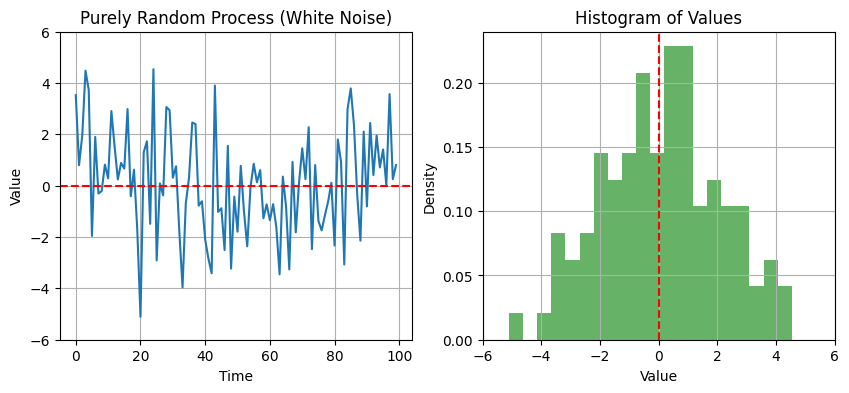

In [2]:
# A purely random process with a standard deviation of 1

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

e = np.random.normal(loc = 0, scale=2, size=100)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(e)
ax[0].set_title("Purely Random Process (White Noise)")
ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_ylim(-6, 6)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Value")
ax[0].grid()

ax[1].hist(e, bins=20, density=True, alpha=0.6, color='g')
ax[1].set_title("Histogram of Values")
ax[1].set_xlim(-6, 6)
ax[1].axvline(0, color='red', linestyle='--')
ax[1].set_xlabel("Value")
ax[1].set_ylabel("Density")
ax[1].grid()

## The Empirical Auto-correlation Function (ACF) 

The (empirical) auto-correlation function (ACF) measures the correlation between observations of a time series separated by various time lags.

The empirical auto-correlation at lag $k$ is defined as:

$$
\hat{\rho}(k) = \frac{\sum_{t=k+1}^{T} (y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum_{t=1}^{T} (y_t - \bar{y})^2}
$$

where the numerator is the empirical covariance at lag $k$ and the denominator is the variance of the series.

The partial auto-correlation function (PACF) measures the correlation between observations of a time series separated by lag $k$, after removing the effects of all shorter lags (1 to $k-1$). We will come back to this later when we discuss AR processes.

Let's compute the ACF of the white noise process manually at first. For this purpose it is convenient to pack the values into a pandas DataFrame first.

In [ ]:
import pandas as pd

df_e = pd.DataFrame(e, columns=["e"])
df_e.head()
# To compute the ACF, we need to compute the lags of e first. We will illustrate 
# this for the first 3 lags

df_e["e_lag1"] = df_e["e"].shift(1)
df_e["e_lag2"] = df_e["e"].shift(2)
df_e["e_lag3"] = df_e["e"].shift(3)

df_e.head()


In [ ]:
# Now all we need to do is compute the correlation of e and e_lag1, e and e_lag2, etc.
# Before we do that, we need to remove the first 3 rows where the lags are not defined.

df_e = df_e.dropna()
df_e.head()

In [ ]:
np.corrcoef([df_e["e"], df_e["e_lag1"], df_e["e_lag2"], df_e["e_lag3"]])

The first row of the output is the correlation between e and e_lag1, e and e_lag2, e and e_lag3.
This is what you see in the ACF plot below, where these auto-correlations are plotted as bars against the lags (on the x-axis).

$$
\begin{align*}
\hat{\rho}(1) & = 0.054 \\
\hat{\rho}(2) & = 0.046 \\
\hat{\rho}(3) & = -0.10 \\
\end{align*}
$$

For a purely random process, the empirical auto-correlations should be small and close to zero because the white noise process is uncorrelated (we have demanded that $Cov(e_t, e_{t-k}) = 0$ for all $k \neq 0$).

The blue ribbon around the x-axis shows a 95% confidence interval for the auto-correlations of a purely random process. Setting the `bartlett_confint=False` argument in the `plot_acf` shows a confidence interval based on the assumption that the process is white noise. For every lag, the empirical auto-correlation is expected to be within this interval 95% of the time if the process is white noise.

The boundaries of the confidence interval are computed as:

$$
\pm 1.96 \sqrt{\frac{1}{T}}
$$


Text(0.5, 1.0, 'Auto-correlation of White Noise')

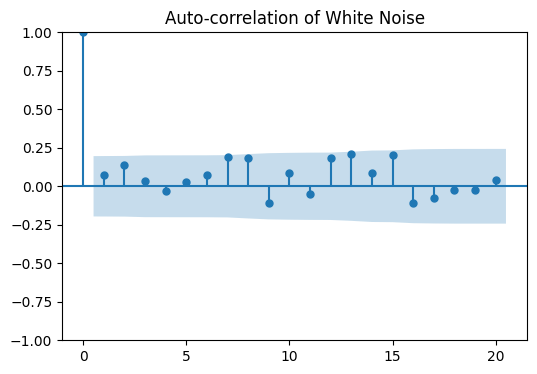

In [3]:
# Auto-correlation
from statsmodels.graphics.tsaplots import plot_acf

fig_acf, ax_acf = plt.subplots(figsize=(6, 4))
plot_acf(e, lags=20, ax=ax_acf)
ax_acf.set_title("Auto-correlation of White Noise")

## Autoregressive Processes (AR)

An autoregressive process of order $p$, denoted as AR($p$), is a stochastic process where the current value of the series is expressed as a linear combination of its previous $p$ values and a random error term.

$$
x_t = \phi_0 + \phi_1 x_{t-1} + \phi_2 x_{t-2} + ... + \phi_p x_{t-p} + e_t
$$

where:
- $x_t$ is the value of the series at time $t$,
- $\phi_1, \phi_2, ..., \phi_p$ are the parameters of the model,
- $e_t$ is a white noise error term with mean zero and constant variance $\sigma^2$.


In the following we want to study the properties of autoregressive processes. Our primary interest is in the expected value, variance and auto-correlation structure of the processes, because when selecting a model for an observed time series we can match the features in the data (observed mean, variance, auto-correlations) with the expected properties of a model.

## Rules for Computing Expectations

When we derive the statistical properties of a process, we rely on the following rules for computing expectations:

If $X$ and $Y$ are random variables and $c$ is a constant (not random), then the following rules apply:

$$
E(X + Y) = E(X) + E(Y)
$$

This means that we can write the expected value of a sum of random variables as the sum of the expected values of the individual variables.

$$
E(cX) = cE(X)
$$

The second rule says that we can factor out constants from the expected value.

$$
E(c) = c
$$

The third rule says that the expected value of a constant is the constant itself.

$$
Var(X) = E(X - E(X))^2 = E(X^2) - E(X)^2
$$

This rule (we will use it without proof) allows us to compute the variance of a random variable as the expected value of the square of the random variable minus the square of its expected value. This is especially useful when the variable has a zero mean (expected value) because then the formula reduces to:

$$
Var(X) = E(X^2)
$$

For the covariance of two random variables $X$ and $Y$, we have:

$$
Cov(X, Y) = E((X - E(X))(Y - E(Y))) = E(XY) - E(X)E(Y)
$$

This rule allows us to compute the covariance of two random variables as the expected value of the product of the two random variables minus the product of their expected values.

Before we proceed it helps to rewrite the properties of the purely random process in terms of expectations. Because the expected value of the process is zero we can apply the rules above to simplify the expressions for the variance and covariances of the process:

$$
\begin{align*}
E(e_t) & = 0 \\
Var(e_t) = E(e_t^2) & = \sigma^2 \\
Cov(e_t, e_{t-k}) = E(e_t e_{t-k}) & = 0 \text{ for } k \neq 0
\end{align*}
$$










## The AR(1) Process

The simplest autoregressive process is the AR(1) process, where the current value depends only on the value that precedes it.

$$
x_t = \phi_0 + \phi_1 x_{t-1} + e_t
$$

In the discussion about difference equations, we saw that the AR(1) is stable if $|\phi| < 1$. What about the statistical properties of the AR(1) process?

In the following we will derive the properties of **stationary** AR processes where the mean, variance and covariances do not change over time. Therefore, we can introduce a more compact notation:

We will write $\mu$ for the mean of the process, i.e. 

$$
\begin{align*}
\mu & = E(x_t),  \forall t \\
\gamma(0) & = Var(x_t), \forall t \\
\gamma(1) & = Cov(x_{t - k}, x_{t -k - 1}), \forall t, k \\
\gamma(2) & = Cov(x_{t - k}, x_{t -k - 2}), \forall t, k \\
\vdots
\end{align*}
$$

In the above notation $\gamma(0)$ is the variance of the process, $\gamma(1)$ is the auto-covariance at lag 1, $\gamma(2)$ the auto-covariance at lag 2, etc.

We will write $\rho(k)$ for the auto-correlations at lag $k$.

$$
\begin{align*}
\rho(0) & = \frac{\gamma(0)}{\gamma(0)} = 1 \\
\rho(1) & = \frac{\gamma(1)}{\gamma(0)} \\
\rho(2) & = \frac{\gamma(2)}{\gamma(0)} \\
\vdots
\end{align*}
$$


### Expected Value (Level)

In the discussion about difference equations, we saw that the AR(1) is stable if $|\phi| < 1$. What about the statistical properties of the AR(1) process?

$$
E(x_t) = \phi_0 + \phi_1 E(x_{t-1}) + E(e_t) \\
$$


If the process is stationary (i.e., $E(x_t) = E(x_{t-1})$), then the mean of the AR(1) process is zero. If 
the process is stationary, then we can solve the equation for the expected value:

$$
E(x_t) = \frac{\phi_0}{1 - \phi_1}
$$


### Variance, Auto-covariances and Auto-correlations

We can calculate the variance of the AR(1) by assuming that $\phi_0 = 0$. This simplifies the calculations without loss of generality.

$$
\begin{align*}
\gamma(0) & = Var(x_t) \\ 
& = E(x_t^2) - [E(x_t)]^2 \\
& = E[(\phi_1 x_{t-1} + e_t)^2] \\
& = E[\phi_1^2 x_{t-1}^2 + 2 \phi_1 x_{t-1} e_t + e_t^2] \\
& = \phi_1^2 E(x_{t-1}^2) + 2 \phi_1 E(x_{t-1} e_t) + E(e_t^2) \\
& = \phi_1^2 Var(x_{t-1}) + \sigma^2 \\
\end{align*}
$$

Again, assuming stationarity ($Var(x_t) = Var(x_{t-1})$), we can solve for the variance:

$$
Var(x_t) = \frac{\sigma^2}{1 - \phi_1^2}
$$

The covariances can be derived similarly by assuming that the constant is zero and taking the expected value of the product $x_t$ and $x_{t-k}$:

$$
\begin{align*}
\gamma(1) = Cov(x_t, x_{t-1}) & = E(x_t x_{t-1})\\
& = E[(\phi_1 x_{t-1} + e_t)x_{t-1}] \\
& = \phi_1 E(x_{t-1}^2) + E(e_t x_{t-1}) \\
& = \phi_1 Var(x_{t-1}) + 0 \\
& = \phi_1 Var(x_{t-1}) \\
& = \phi_1 Var(x_t) \\
\end{align*}
$$

For $k = 2$, we have:

$$
\begin{align*}
\gamma(2) = Cov(x_t, x_{t-2}) & = E(x_t x_{t-2})\\
& = E[(\phi_1 x_{t-1} + e_t)x_{t-2}] \\
& = \phi_1 E(x_{t-1} x_{t-2}) + E(e_t x_{t-2}) \\
& = \phi_1 \gamma(1) + 0 \\
& = \phi_1^2 \gamma(0) \\
\end{align*}
$$

Continuing this process, we find that for any lag $k$:

$$
\gamma(k) = \phi_1^k Var(x_t)
$$

The autocorrelation function (ACF) is obtained by normalizing the covariances by the variance:

$$
\rho(k) = \frac{\gamma(k)}{\gamma(0)} = \phi_1^k
$$


For an AR(p) process the expressions for the mean, variance, and autocovariances are more complex and involve solving a system of equations known as the Yule-Walker equations.

1. Assume a zero mean for simplicity.

$$
x_t = \phi_1 x_{t-1} + \phi_2 x_{t-2} + ... + \phi_p x_{t-p} + e_t
$$

The first Yule-Walker equation is for the variance:

$$
\begin{align*}
\gamma(0) & = E(x_t (\phi_1 x_{t-1} + \phi_2 x_{t-2} + ... + \phi_p x_{t-p} + e_t)) \\
& = \phi_1 E(x_t x_{t-1}) + \phi_2 E(x_t x_{t-2}) + ... + \phi_p E(x_t x_{t-p}) + E(x_t e_t) \\
& = \phi_1 \gamma(1) + \phi_2 \gamma(2) + ... + \phi_p \gamma(p) + \sigma^2 \\
\end{align*}
$$

The next equation is for the autocovariance at lag 1:

$$
\begin{align*}
\gamma(1) & = E(x_{t-1} (\phi_1 x_{t-1} + \phi_2 x_{t-2} + ... + \phi_p x_{t-p} + e_t)) \\
& = \phi_1 E(x_{t-1} x_{t-1}) + \phi_2 E(x_{t-1} x_{t-2}) + ... + \phi_p E(x_{t-1} x_{t-p}) + E(x_{t-1} e_t) \\
& = \phi_1 \gamma(0) + \phi_2 \gamma(1) + ... + \phi_p \gamma(p-1) + 0 \\
\end{align*}
$$


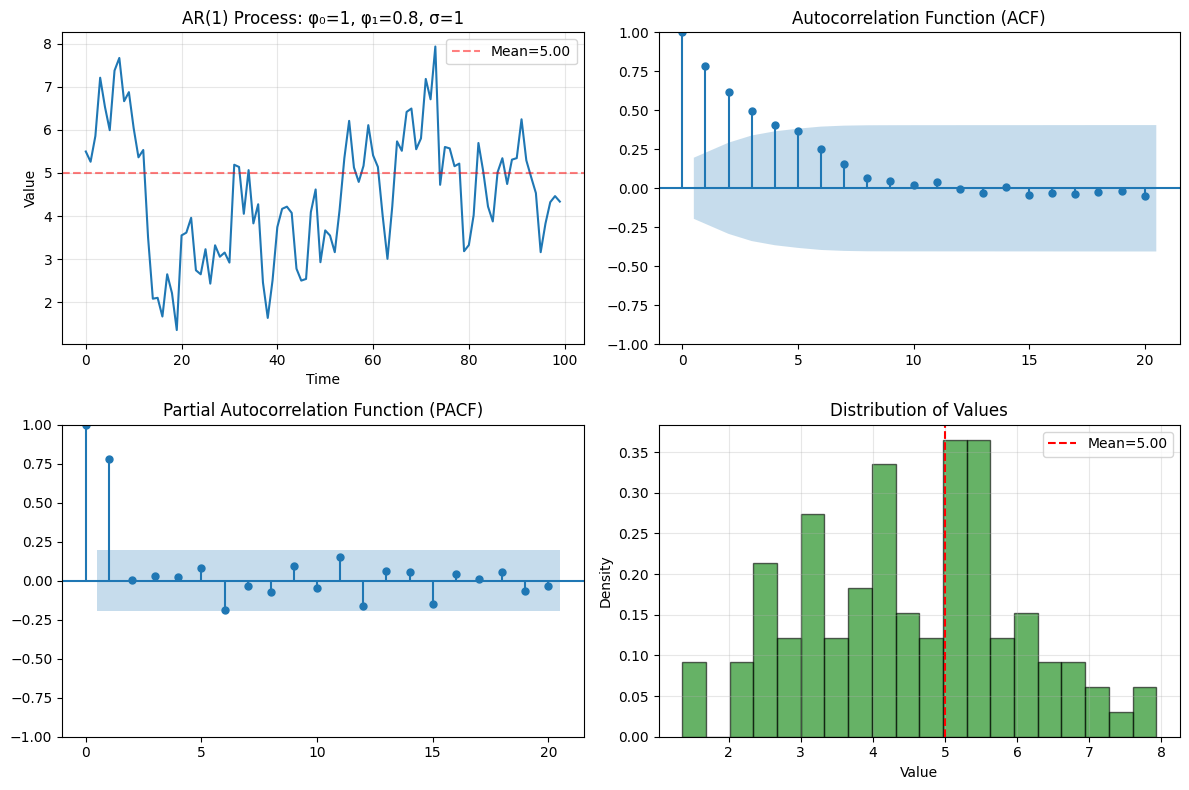

Sample statistics:
  Mean: 4.5073
  Variance: 2.1217

Theoretical properties:
  Mean: 5.0000
  Variance: 2.7778
  ACF at lag k: ρ(k) = φ₁^k = 0.8^k


In [4]:
# Simulate AR(1) process with phi_0 = 1, phi_1 = 0.8, sigma = 1

from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_pacf

np.random.seed(42)

# AR(1) parameters
phi_0 = 1  # constant term
phi_1 = 0.8  # AR coefficient
sigma = 1  # standard deviation of noise
n = 100

# For arma_generate_sample:
# ar parameter: [1, -phi_1] (note the negative sign for the lag polynomial)
# ma parameter: [1] for no MA component
ar = np.array([1, -phi_1])
ma = np.array([1])

# Generate AR(1) sample
x = arma_generate_sample(ar, ma, nsample=n, scale=sigma)

# Add the constant term to achieve the correct mean
# Mean of AR(1) is phi_0 / (1 - phi_1)
mean_ar1 = phi_0 / (1 - phi_1)
x = x + mean_ar1

# Plot the AR(1) process
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Time series plot
ax[0, 0].plot(x)
ax[0, 0].set_title(f"AR(1) Process: φ₀={phi_0}, φ₁={phi_1}, σ={sigma}")
ax[0, 0].axhline(mean_ar1, color='red', linestyle='--', alpha=0.5, label=f'Mean={mean_ar1:.2f}')
ax[0, 0].set_xlabel("Time")
ax[0, 0].set_ylabel("Value")
ax[0, 0].grid(alpha=0.3)
ax[0, 0].legend()

# ACF plot
plot_acf(x, lags=20, ax=ax[0, 1])
ax[0, 1].set_title("Autocorrelation Function (ACF)")

# PACF plot
plot_pacf(x, lags=20, ax=ax[1, 0])
ax[1, 0].set_title("Partial Autocorrelation Function (PACF)")

# Histogram
ax[1, 1].hist(x, bins=20, density=True, alpha=0.6, color='g', edgecolor='black')
ax[1, 1].set_title("Distribution of Values")
ax[1, 1].axvline(mean_ar1, color='red', linestyle='--', label=f'Mean={mean_ar1:.2f}')
ax[1, 1].set_xlabel("Value")
ax[1, 1].set_ylabel("Density")
ax[1, 1].legend()
ax[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Theoretical properties
theoretical_mean = phi_0 / (1 - phi_1)
theoretical_var = sigma**2 / (1 - phi_1**2)

print(f"Sample statistics:")
print(f"  Mean: {np.mean(x):.4f}")
print(f"  Variance: {np.var(x):.4f}")
print(f"\nTheoretical properties:")
print(f"  Mean: {theoretical_mean:.4f}")
print(f"  Variance: {theoretical_var:.4f}")
print(f"  ACF at lag k: ρ(k) = φ₁^k = {phi_1}^k")

## The Partial Autocorrelation Function (PACF) and AR Models

The meaning and usefulness of the PACF can become more clear with an example of an AR(2) process.

$$
x_t = \phi_1 x_{t-1} + \phi_2 x_{t-2} + e_t
$$

The correlation between $x_t$ and $x_{t-2}$ can arise from two sources:

- The obvious source is the direct influence of $x_{t-2}$ on $x_t$ through the parameter $\phi_2$ (because $x_{t-2}$ is included in the equation for $x_t$).
- The slightly less obvious one is through $x_{t-1}$. Since $x_{t-1}$ is influenced by $x_{t-2}$. To see this, write the model equation 
  for $x_{t-1}$:

$$
x_{t-1} = \phi_1 x_{t-2} + \phi_2 x_{t-3} + e_{t-1}
$$

When looking at ACF plots it is not possible to distinguish between these two sources of correlation as the autocorrelation at lag 2 includes both effects. The purpose of the PACF is to isolate the direct effect of $x_{t-2}$ on $x_t$ by removing the indirect effect that is mediated through $x_{t-1}$. The usefulness of the PACF lies in the fact that for an AR(p) process, the PACF will be zero for all lags greater than $p$ because these lags do not appear in the model equation. 

For example: 

- in an AR(1) process, the PACF will be zero for all lags greater than 1 and non-zero for lag 1.
- in an AR(2) process, the PACF will be zero for all lags greater than 2 and non-zero for lags 1 and 2.
- in an AR(3) process, the PACF will be zero for all lags greater than 3 and non-zero for lags 1, 2, and 3, because the fourth lag does not appear in the model equation and neither do any higher lags.


## Partial Autocorrelation and Regression

$$
\text{income}_i = \beta_0 + \beta_1 \text{age}_{i} + \beta_2 \text{experience}_{i} + e_i 
$$

In [ ]:
import pandas as pd

dt = pd.read_csv("https://raw.githubusercontent.com/febse/data/refs/heads/main/ts/multiple_linear_regression_dataset_age_income_experience.csv")
dt.head()

,age,experience,income
0,25,1,30450
1,30,3,35670
2,47,2,31580
3,32,5,40130
4,43,10,47830


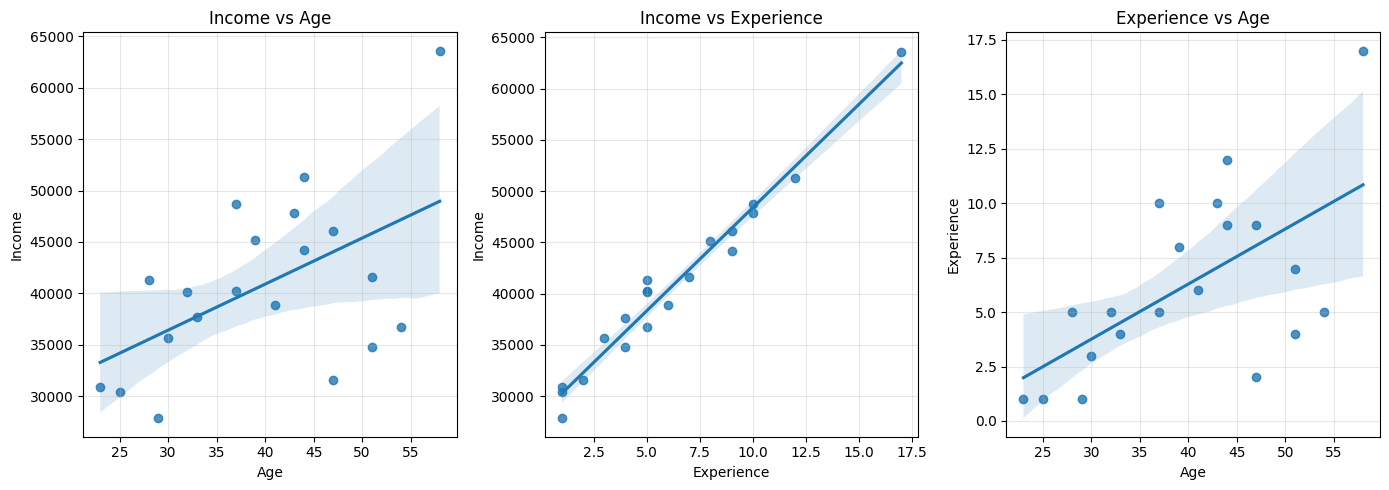

In [ ]:
# Plot income vs age and experience with regression lines using seaborn
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(14, 5))

# Income vs Age
sns.regplot(x='age', y='income', data=dt, ax=ax[0])
ax[0].set_title("Income vs Age")
ax[0].set_xlabel("Age")
ax[0].set_ylabel("Income")
ax[0].grid(alpha=0.3)

# Income vs Experience
sns.regplot(x='experience', y='income', data=dt, ax=ax[1])
ax[1].set_title("Income vs Experience")
ax[1].set_xlabel("Experience")
ax[1].set_ylabel("Income")
ax[1].grid(alpha=0.3)

# Income vs Hours Worked
sns.regplot(x='age', y='experience', data=dt, ax=ax[2])
ax[2].set_title("Experience vs Age")
ax[2].set_xlabel("Age")
ax[2].set_ylabel("Experience")
ax[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
from pyexpat import model
from statsmodels.formula.api import ols

model_both = ols('income ~ age + experience', data=dt).fit()
print(model_both.params)


Intercept     31261.689854
age             -99.195355
experience     2162.404192
dtype: float64


In [ ]:
model_income_experience = ols('income ~ experience', data=dt).fit()
print(model_income_experience.params)


Intercept     28248.446782
experience     2014.040842
dtype: float64


To calculate the partial correlation between income and experience, controlling for age, we
regress income on age and compute the residuals. We then regress experience on age and compute the residuals. Finally, we calculate the correlation between the two sets of residuals. This correlation is the partial correlation between income and experience, controlling for age.

In [ ]:
model_experience_age = ols('age ~ experience', data=dt).fit()
print(model_experience_age.params)

Intercept     30.376856
experience     1.495668
dtype: float64


In [ ]:
# The correlation coefficient between income and age

np.corrcoef(dt["income"], dt["age"])

array([[1.        , 0.53220434],
       [0.53220434, 1.        ]])

In [ ]:
# The partial correlation coefficient between income and age controlling for experience

np.corrcoef(model_income_experience.resid, model_experience_age.resid)

array([[ 1.        , -0.52523009],
       [-0.52523009,  1.        ]])

In [ ]:
model_income_experience.resid

0      187.512376
1     1379.430693
2     -696.528465
3     1811.349010
4     -558.855198
5     -716.732673
6     3021.349010
7     1345.389851
8     1931.349010
9      789.226485
10   -2422.487624
11    -264.814356
12   -1598.650990
13   -1504.610149
14   -1116.936881
15   -1432.691832
16    1112.858911
17     607.512376
18   -2184.814356
19     311.144802
dtype: float64

## Moving Average (MA) Processes

A simple moving average process of order $q$, denoted as MA(q), is defined as:

$$
x_t = e_t + \theta_1 e_{t-1} + \theta_2 e_{t-2} + ... + \theta_q e_{t-q}
$$

where:
- $x_t$ is the value of the time series at time $t$.
- $e_t$ is a white noise error term at time $t$.
- $\theta_1, \theta_2, ..., \theta_q$ are the parameters of the model.

The moving average process of order 1 only includes the immediate past error term:

$$
x_t = e_t + \theta_1 e_{t-1}
$$

The expected value of this process is zero, because it is a linear combination of white noise terms, each of which has an expected value of zero.

$$
E(x_t) = E(e_t) + \theta_1 E(e_{t-1}) = 0 + \theta_1 \cdot 0 = 0
$$

We can calculate its variance by using the result that its mean is zero (see above). 

$$
\begin{align*}
Var(x_t) & = E(x_t^2) \\
         & = E\left((e_t + \theta_1 e_{t-1})^2\right) \\
         & = E\left(e_t^2 + 2\theta_1 e_t e_{t-1} + \theta_1^2 e_{t-1}^2\right) \\
         & = E(e_t^2) + 2\theta_1 E(e_t e_{t-1}) + \theta_1^2 E(e_{t-1}^2) \\        
         & = \sigma^2 + 2\theta_1 \cdot 0 + \theta_1^2 \sigma^2 \\
         & = (1 + \theta_1^2) \sigma^2
\end{align*}
$$

Its autocovariance function (ACF) at lag $k = 1$ is given by:

$$
\begin{align*}
\gamma(1) & = Cov(x_t, x_{t-1}) \\
          & = E\left[(x_t - E(x_t))(x_{t-1} - E(x_{t-1}))\right] \\
          & = E(x_t x_{t-1}) \\
          & = E\left[(e_t + \theta_1 e_{t-1})(e_{t-1} + \theta_1 e_{t-2})\right] \\
          & = E\left[e_t e_{t-1} + \theta_1 e_t e_{t-2} + \theta_1 e_{t-1}^2 + \theta_1^2 e_{t-1} e_{t-2}\right] \\
          & = 0 + \theta_1 \cdot 0 + \theta_1 \sigma^2 + \theta_1^2 \cdot 0 \\
          & = \theta_1 \sigma^2
\end{align*}
$$

Its autocovariance function (ACF) at lag $k > 1$ is zero, see for example lag $k = 2$ below:

$$
\begin{align*}
\gamma(2) & = E(x_t x_{t-2}) \\
          & =  E\left[(e_t + \theta_1 e_{t-1})(e_{t-1} + \theta_1 e_{t-2})\right] \\
          & = E\left[e_t e_{t-2} + \theta_1 e_{t-1} e_{t-2} + \theta_1 e_t e_{t-1} + \theta_1^2 e_{t-1} e_{t-2}\right] \\
          & = 0 + \theta_1 \cdot 0 + \theta_1 \cdot 0 + \theta_1^2 \cdot 0 \\
          & = 0
\end{align*}          
$$


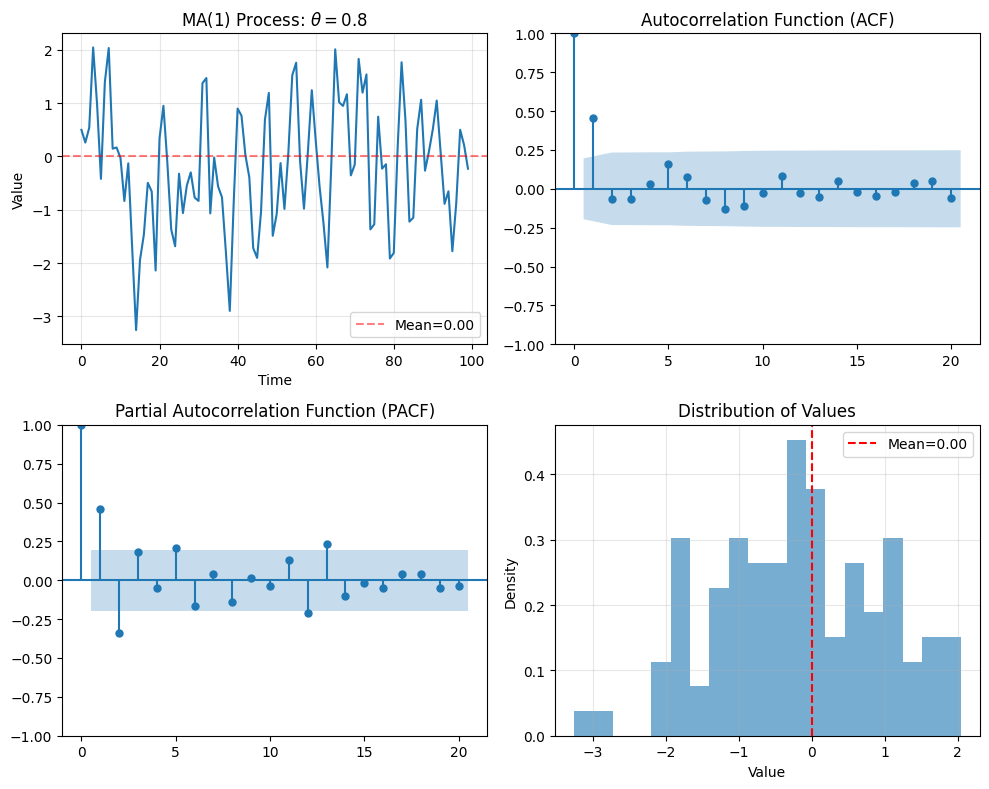

In [ ]:
# Simulate MA(1) process with theta = 0.8, sigma = 1

from statsmodels.tsa.arima_process import arma_generate_sample

np.random.seed(42)

# MA(1) parameters
theta = 0.8
n = 100

# Generate MA(1) sample
x = arma_generate_sample(ar=[1], ma=[1, theta], nsample=n, scale=1)

# Plot the MA(1) process
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# Time series plot
ax[0, 0].plot(x)
ax[0, 0].set_title(fr"MA(1) Process: $\theta ={theta}$")
ax[0, 0].axhline(0, color='red', linestyle='--', alpha=0.5, label=f'Mean={0:.2f}')
ax[0, 0].set_xlabel("Time")
ax[0, 0].set_ylabel("Value")
ax[0, 0].grid(alpha=0.3)
ax[0, 0].legend()

# ACF plot

plot_acf(x, lags=20, ax=ax[0, 1])
ax[0, 1].set_title("Autocorrelation Function (ACF)")

# PACF plot
plot_pacf(x, lags=20, ax=ax[1, 0])
ax[1, 0].set_title("Partial Autocorrelation Function (PACF)")
# Histogram
ax[1, 1].hist(x, bins=20, density=True, alpha=0.6)
ax[1, 1].set_title("Distribution of Values")
ax[1, 1].axvline(0, color='red', linestyle='--', label=f'Mean={0:.2f}')
ax[1, 1].set_xlabel("Value")
ax[1, 1].set_ylabel("Density")
ax[1, 1].legend()
ax[1, 1].grid(alpha=0.3)
plt.tight_layout()
plt.show()